## ` 01, 02, 03, 04 `   _______________   ` part2_01_PEST SETUP ` _____________ pstfrom

In [1]:
import sys
import os
import shutil
import platform
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import pyemu
import flopy                          
sys.path.insert(0,"..")
import herebedragons as hbd

In [2]:
# assert "dependencies" in flopy.__file__      # assert "dependencies" in pyemu.__file__

In [3]:
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
tmp_d = os.path.join('v1_Pstfrom_data_IN_Frey')                                                           # New folder
if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)
hbd.prep_bins(tmp_d)                                      # get executables                 _____ org_d  ____   tmp_d _____
hbd.prep_deps(tmp_d)                                      # get dependency folders

In [4]:
# os.listdir(tmp_d)                                      `GUI ___PstFrom` 
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)           # simulation                          
gwf = sim.get_model()                                     # flow model
pyemu.os_utils.run("mf6",cwd=tmp_d)                       # run _________________________________ made beforehand with flopy 

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package wel...
    loading package rch...
    loading package ghb...
    loading package sfr...
    loading package obs...
  loading solution package freyberg6...
mf6.exe


## ` 05 ___ Spatial Reference`

In [5]:
sr = pyemu.helpers.SpatialReference.from_namfile(os.path.join(tmp_d, "freyberg6.nam"),                               
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)                 
# sr

   could not remove start_datetime


In [6]:
template_ws = os.path.join("v1_Pstfrom_Katie_new_folder")                    # New Folder !
start_datetime="1-1-2008"

pf = pyemu.utils.PstFrom(original_d=tmp_d,                 # PROJECT
                            new_d=template_ws,             # folder
                            remove_existing=True,           
                            longnames=True,                 
                            spatial_reference=sr,          # spatial reference
                            zero_based=False,              
                            start_datetime=start_datetime, # temporal correlation
                            echo=False)                    

# <font color='blue'> 06 __ OBS </font>

In [7]:
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)              # Loading dataframe (PANDAS)
hds_df = pf.add_observations("heads.csv",                                
                            insfile="heads.csv.ins",                             # INS ____ to pst
                            index_cols="time",                           
                            use_cols=list(df.columns.values),            
                            prefix="hds")                                

df = pd.read_csv(os.path.join(template_ws, "sfr.csv"), index_col=0)      
sfr_df = pf.add_observations("sfr.csv", 
                            insfile="sfr.csv.ins", 
                            index_cols="time", 
                            use_cols=list(df.columns.values),                    # index   
                            prefix="sfr")                                

In [8]:
# df.tail()            # df.head()                                               # sfr __no__

In [9]:
# hds_df.head()        # sfr_df.head()

In [10]:
pst = pf.build_pst()    

noptmax:0, npar_adj:0, nnz_obs:400


# <font color='red'> 07 __ PAR </font>

In [11]:
# len([f for f in os.listdir(template_ws) if f.endswith(".txt")])

In [12]:
# len([f for f in os.listdir(template_ws) if f.endswith(".tpl")])

### <font color='red'> Geostatistics ____________________ </font> Kh, Kv, Ss, Sy, RCH (xyz,T). GHB, SFR, WELL (,T)

In [13]:
v_grid = pyemu.geostats.ExpVario(contribution=1.0, a=1000, anisotropy=1.0,bearing=0.0)
grid_gs = pyemu.geostats.GeoStruct(variograms=v_grid, transform='log')                     # _____  grid_gs          # ax = grid_gs.plot()                                          

v_pp = pyemu.geostats.ExpVario(contribution=1.0, a=15000, anisotropy=1.0, bearing=0.0)
pp_gs = pyemu.geostats.GeoStruct(variograms=v_pp, transform='log')                         # _____  pp_gs            # _ = pp_gs.plot()            

v_time = pyemu.geostats.ExpVario(contribution=1.0, a=60, anisotropy=1.0, bearing=0.0)
temporal_gs = pyemu.geostats.GeoStruct(variograms=v_time, transform='none')                # ______ tempotal_gs      # ax = v_time.plot()

### `07a __ K       ` GRID ______ PILOT POINTS ______ CTE

In [14]:
# plot    df = pf.add_observations(f,prefix="hk",zone_array=ib)        df 
# df_gr.tail()

In [15]:
tag = "npf_k_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")] 
print(files) 
ib = gwf.dis.idomain.array[0]                                         # inactive cells        # ib        # plt.imshow(ib)  

f = 'freyberg6.npf_k_layer1.txt'
df_pp = pf.add_parameters(f, zone_array=ib, par_type="pilotpoints", geostruct=pp_gs,          # __________________ pp_gs
                par_name_base=f.split('.')[1].replace("_","")+"pp",
                pargp=f.split('.')[1].replace("_","")+"pp",
                ult_ubound=100, upper_bound=5.0,      lower_bound=0.2, ult_lbound=0.01, pp_space=5)  # ___________ Position  

['freyberg6.npf_k_layer1.txt']
starting interp point loop for 706 points
starting 0
starting 1
starting 2
starting 3
starting 4
starting 5
starting 6
starting 7
starting 8
starting 9
took 4.158493 seconds


## <font color='red'> 07d __ PAR </font>  _____ sto_ss, _____ sto_sy, _____ ne_  

In [16]:
tag = "sto_ss"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg6.sto_ss_layer1.txt']


In [17]:
f = 'freyberg6.sto_ss_layer1.txt'
df_pp = pf.add_parameters(f, zone_array=ib, par_type="pilotpoints", geostruct=pp_gs,          # __________________ pp_gs
                par_name_base=f.split('.')[1].replace("_","")+"pp",
                pargp=f.split('.')[1].replace("_","")+"pp",
                ult_ubound=0.2, upper_bound=5.0,      lower_bound=1e-3, ult_lbound=1e-7, pp_space=10)  # ___________ Position  

starting interp point loop for 706 points
starting 0
starting 1
starting 2
starting 3
starting 4
starting 5
starting 6
starting 7
starting 8
starting 9
took 3.704677 seconds


In [18]:
f = 'freyberg6.sto_sy_layer1.txt'
df_pp = pf.add_parameters(f, zone_array=ib, par_type="pilotpoints", geostruct=pp_gs,          # __________________ pp_gs
                par_name_base=f.split('.')[1].replace("_","")+"pp",
                pargp=f.split('.')[1].replace("_","")+"pp",
                ult_ubound=0.2, upper_bound=5.0,      lower_bound=0.4, ult_lbound=0.01, pp_space=10)  # ___________ Position  

In [19]:
tag = "ne_"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
print(files)

['freyberg_mp.ne_layer1.txt', 'freyberg_mp.ne_layer2.txt', 'freyberg_mp.ne_layer3.txt']


In [20]:
f = 'freyberg_mp.ne_layer1.txt'
df_pp = pf.add_parameters(f, zone_array=ib, par_type="pilotpoints", geostruct=pp_gs,          # __________________ pp_gs
                par_name_base=f.split('.')[1].replace("_","")+"pp",
                pargp=f.split('.')[1].replace("_","")+"pp",
                ult_ubound=0.2, upper_bound=5.0,      lower_bound=0.4, ult_lbound=0.01, pp_space=10)  # ___________ Position  

In [21]:
f = 'freyberg_mp.ne_layer2.txt'
df_pp = pf.add_parameters(f, zone_array=ib, par_type="pilotpoints", geostruct=pp_gs,          # __________________ pp_gs
                par_name_base=f.split('.')[1].replace("_","")+"pp",
                pargp=f.split('.')[1].replace("_","")+"pp",
                ult_ubound=0.2, upper_bound=5.0,      lower_bound=0.4, ult_lbound=0.01, pp_space=10)  # ___________ Position  

In [22]:
f = 'freyberg_mp.ne_layer3.txt'
df_pp = pf.add_parameters(f, zone_array=ib, par_type="pilotpoints", geostruct=pp_gs,          # __________________ pp_gs
                par_name_base=f.split('.')[1].replace("_","")+"pp",
                pargp=f.split('.')[1].replace("_","")+"pp",
                ult_ubound=0.2, upper_bound=5.0,      lower_bound=0.4, ult_lbound=0.01, pp_space=10)  # ___________ Position  

In [23]:
len([f for f in os.listdir(template_ws) if f.endswith(".tpl")])

6

## <font color='red'> 08 __ x,y,z,T  </font> ______ `DIS Recharge (RCH) `_______ ` tDIS temp ` 

In [24]:
dts = pd.to_datetime(start_datetime) + pd.to_timedelta(np.cumsum(sim.tdis.perioddata.array["perlen"]),unit='d') # container # dts   

In [25]:
tag = "rch_recharge"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
sp = [int(f.split(".")[1].split('_')[-1]) for f in files]
d = {s:f for s,f in zip(sp,files)}
sp.sort()
files = [d[s] for s in sp]                                                            
# print(files)

In [26]:
for f in files:                                                           
    kper = int(f.split('.')[1].split('_')[-1]) - 1                                    # temporal correlation _______________ RCH 
    pf.add_parameters(filenames=f, zone_array=ib, par_type="constant",                # ____________________________________ tDIS  
                    par_name_base=f.split('.')[1]+"tcn", pargp=f.split('.')[1]+"tcn",
                    ult_lbound=0, upper_bound=1.5,       lower_bound=0.5, ult_ubound=1e-3,
                    datetime=dts[kper], geostruct=temporal_gs)  

In [27]:
len([f for f in os.listdir(template_ws) if f.endswith(".tpl")])    

31

In [28]:
pst = pf.build_pst()                                    # ________________________________________________  *. pst _____01 

noptmax:0, npar_adj:89, nnz_obs:400


## ` 09 ___ List Files __GHB Head (add) and Conductance (mult) ` <font color='greein'> ___  boundary-condition A </font> 

In [29]:
# tag = "ghb_stress_period_data"
# files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]            # 
# print(files) 

In [30]:
tag = "ghb_stress_period_data"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
for f in files:
    
    name = 'ghbcond'                                         
#    pf.add_parameters(f, par_type="grid", geostruct=grid_gs,           # ____________________________________    
#                        par_name_base=name+"gr", pargp=name+"gr",
#                        index_cols=[0,1,2], upper_bound=10.0, use_cols=[4], lower_bound=0.1)      # ____col ____ 10 < 4 < 0.1
    
    pf.add_parameters(f, par_type="constant", geostruct=grid_gs,       # ____________________________________ 
                        par_name_base=name+"cn", pargp=name+"cn",
                        index_cols=[0,1,2], ult_ubound=100, upper_bound=10.0, use_cols=[4], lower_bound=0.1, ult_lbound=0.01, )      
    
    name = 'ghbhead'   
#    pf.add_parameters(f, par_type="grid", geostruct=grid_gs,           # ____________________________________ 
#                       par_name_base=name+"gr", pargp=name+"gr",
#                        index_cols=[0,1,2], ult_ubound=42, upper_bound=2.0, use_cols=[3], lower_bound=-2.0, ult_lbound=32.5,
#                        par_style="a", transform="none")       
    
    pf.add_parameters(f, par_type="constant", geostruct=grid_gs,       # ____________________________________   
                        par_name_base=name+"cn", pargp=name+"cn",
                        index_cols=[0,1,2], ult_ubound=42, upper_bound=2.0, use_cols=[3], lower_bound=-2.0, ult_lbound=32.5,
                        par_style="a", transform="none")                                                                           # added

In [31]:
pst = pf.build_pst()   # ________________________________________________________________* pst 04 __________

noptmax:0, npar_adj:91, nnz_obs:400


## `10 ___ Pumping rates ___`  well parametrization <font color='greein'> ___  boundary-condition B </font> 

In [32]:
# tag = "wel_stress_period_data"
# files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")] 
# print(files) 

In [33]:
files = [f for f in os.listdir(template_ws) if "wel_stress_period_data" in f and f.endswith(".txt")]
sp = [int(f.split(".")[1].split('_')[-1]) for f in files]
d = {s:f for s,f in zip(sp,files)}
sp.sort()
files = [d[s] for s in sp]

for f in files:
    kper = int(f.split('.')[1].split('_')[-1]) - 1                                            
    
#    pf.add_parameters(filenames=f, index_cols=[0,1,2],                                     # ____________________________________ Well      
#                        par_type="grid", par_name_base="welgrd", pargp="welgrd", 
#                        upper_bound = 4, use_cols=[3], lower_bound=0.25,                   # ____ 4 < 3 < 0.25 
#                        datetime=dts[kper])                                                 # added

    pf.add_parameters(filenames=f, index_cols=[0,1,2],                                     # ____________________________________ Well 
                        par_type="constant", par_name_base="welcst", pargp="welcst", 
                        upper_bound = 4, use_cols=[3], lower_bound=0.25,                    
                        datetime=dts[kper], geostruct=temporal_gs)

In [34]:
pst = pf.build_pst()   # ________________________________________________________________* pst 04 __________

noptmax:0, npar_adj:116, nnz_obs:400


## `11 ___ SFR Conductance ___` (+) time-invariant `inflow`   <font color='greein'> ___  boundary-condition C </font> 

In [35]:
# tag = "sfr_packagedata"
# files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")] # print(files) supressed
# tag = "sfr_perioddata"
# files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")] # print(files) supressed

In [36]:
tag = "sfr_packagedata"
files = [f for f in os.listdir(template_ws) if tag in f.lower() and f.endswith(".txt")]
assert len(files) == 1                                 
print(files)                            # ___________________ ?

['freyberg6.sfr_packagedata.txt']


In [37]:
f = files[0]                                            
name = "sfrcond"
#pf.add_parameters(f,par_type="grid", geostruct=grid_gs, par_name_base=name+"gr", pargp=name+"gr",           # _____________ Conductance ___ sfr   
#                index_cols=[0,2,3], upper_bound=10.0, use_cols=[9], lower_bound=0.1)

pf.add_parameters(f, par_type="constant", geostruct=grid_gs, par_name_base=name+"cn", pargp=name+"cn",
                index_cols=[0,2,3], ult_ubound=100, upper_bound=10.0, use_cols=[9], lower_bound=0.1, ult_lbound=0.001)      

files = [f for f in os.listdir(template_ws) if "sfr_perioddata" in f and f.endswith(".txt")]
sp = [int(f.split(".")[1].split('_')[-1]) for f in files]
d = {s:f for s,f in zip(sp,files)}
sp.sort()
files = [d[s] for s in sp]                                     

for f in files:
    kper = int(f.split('.')[1].split('_')[-1]) - 1                                          
    pf.add_parameters(filenames=f, par_type="grid", par_name_base="sfrgr", pargp="sfrgr",                   # _____________ INFLOW  ___ sfr
                        index_cols=[0], upper_bound = 10, use_cols=[2], lower_bound=0.1,     
                        datetime=dts[kper], geostruct=temporal_gs)                                           # grid ____ ?

In [38]:
pst = pf.build_pst()   # ________________________________________________________________* pst 04 __________

noptmax:0, npar_adj:118, nnz_obs:400


# 12 ____  Initial conditions 

In [39]:
files = [f for f in os.listdir(template_ws) if "ic_strt" in f and f.endswith(".txt")]
files
for f in files:
    base = f.split(".")[1].replace("_","")
    df = pf.add_parameters(f,par_type="grid",par_style="d", par_name_base=base, pargp=base,
                           upper_bound=50,lower_bound=15, zone_array=ib, transform="none")
    print(df.shape)

(706, 17)


In [40]:
pst = pf.build_pst()   # ________________________________________________________________* pst 04 __________

noptmax:0, npar_adj:824, nnz_obs:400


# 13, 14 _______ __Forward__   __PEST__ ___________ __Sys Commands__

In [41]:
pf.mod_sys_cmds 
pf.mod_sys_cmds.append("mf6")                    
pf.mod_sys_cmds
# pst = pf.build_pst()
# _ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

['mf6']

## <font color='magenta'> 16 (15) ____ Secondary Observations </font> _____________________________________ * pst 04 __________

In [42]:
import helpers
helpers.process_secondary_obs(ws=template_ws)  # [f for f in os.listdir(template_ws) if f.endswith(".csv")]
pf.add_py_function("helpers.py",                                               
                    "process_secondary_obs(ws='.')",                           
                    is_pre_cmd=False)                                          # before | after* the model system command

Secondary observation files processed.


In [43]:
df = pd.read_csv(os.path.join(template_ws, "sfr.tdiff.csv"), index_col=0)      # Add..___ = emporal-differences between OBS
_ = pf.add_observations("sfr.tdiff.csv",                                       
                            insfile="sfr.tdiff.csv.ins",                       # NEW AUX OBS ____ sfr.tdiff _______ sfrtd
                            index_cols="time",                                 
                            use_cols=list(df.columns.values),                 
                            prefix="sfrtd")                                    
                            
df = pd.read_csv(os.path.join(template_ws, "heads.tdiff.csv"), index_col=0)
_ = pf.add_observations("heads.tdiff.csv", 
                            insfile="heads.tdiff.csv.ins",                     # NEW AUX OBS ____ heads.tdiff _____ hdstd 
                            index_cols="time", 
                            use_cols=list(df.columns.values), 
                            prefix="hdstd")                                    # just || time and positions || 

In [44]:
# _ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]  
# `extract_hds_array_and_list_dfs()`
# obs = pst.observation_data  # obs  

# <font color='magenta'> 15 (16) ____ [pre-post]-Processing </font> Heads & MB ____________ * pst 03 __________

In [45]:
pf.add_py_function("helpers.py","extract_hds_arrays_and_list_dfs()",is_pre_cmd=False)      

helpers.test_extract_hds_arrays(template_ws)
files = [f for f in os.listdir(template_ws) if f.startswith("hdslay")]
for f in files:
    pf.add_observations(f,prefix=f.split(".")[0],obsgp=f.split(".")[0])              # ______________ Heads of all modelled cells ______________
# files = [f for f in os.listdir(template_ws) if f.startswith("hdslay")]             # files

for f in ["inc.csv","cum.csv"]:
    df = pd.read_csv(os.path.join(template_ws,f),index_col=0)
    pf.add_observations(f,index_cols=["totim"],use_cols=list(df.columns.values),
                        prefix=f.split('.')[0],obsgp=f.split(".")[0])                # ______________ Mass Balance ____________________

pst = pf.build_pst()                               # ________________________________* pst 03 __________

noptmax:0, npar_adj:824, nnz_obs:21250


## `18 ____ Fixing possible trouble "addictive mode of ...  " GHB_heads 

In [46]:
head_pargps = [i for i in pst.adj_par_groups if 'head' in i]

pst.parameter_groups.loc[head_pargps, 'inctyp'] = 'absolute'
par = pst.parameter_data
par_names = par.loc[par.parval1==0].parnme                    

offset = -10
par.loc[par_names, 'offset'] = offset
par.loc[par_names, ['parval1', 'parlbnd', 'parubnd']] -= offset

In [47]:
# head_pargps
# par.loc[par_names].head()

## 19 ____ Forecasts ____ __"right at the beginning"__

In [48]:
forecasts =['oname:sfr_otype:lst_usecol:tailwater_time:4383.5',
            'oname:sfr_otype:lst_usecol:headwater_time:4383.5',
            'oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5',
            'part_time']
# forecasts

In [49]:
# fobs = obs.loc[forecasts,:]
# fobs

In [50]:
pst.pestpp_options['forecasts'] = forecasts

## <font color='green'> __20__ __Write____ NEW _ PEST control file __.pst__04__ _____________ * external files </font>  

In [51]:
pst.write(os.path.join(template_ws, 'v1_Pstfrom_data_IN_Frey.pst'),version=2)          # First time written 

noptmax:0, npar_adj:824, nnz_obs:21250


In [52]:
pyemu.os_utils.run('pestpp-glm v1_Pstfrom_data_IN_Frey.pst', cwd=template_ws)

pestpp-glm.exe v1_Pstfrom_data_IN_Frey.pst


In [53]:
iobj = pd.read_csv(os.path.join(template_ws, 'v1_Pstfrom_data_IN_Frey.iobj'))
iobj.total_phi

0    0
Name: total_phi, dtype: int64

# <font color='green'> 21 ____ Prior Parameter Covariance Matrix </font>

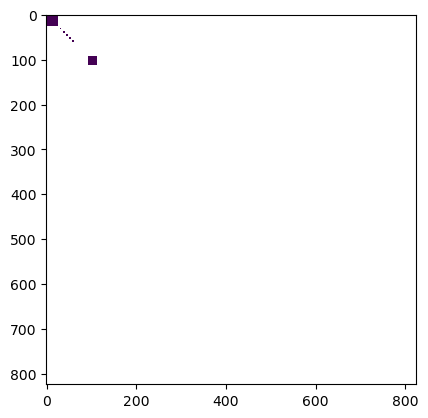

In [54]:
if pf.pst.npar < 35000:  
    cov = pf.build_prior(fmt='coo', filename=os.path.join(template_ws,"prior_cov.jcb"))
    try: 
        x = cov.x.copy()
        x[x==0] = np.NaN
        plt.imshow(x[:1000,:1000])
    except:
        pass

In [55]:
cov.row_names[:10]

['pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:2_zone:1',
 'pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:7_zone:1',
 'pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:12_zone:1',
 'pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:17_zone:1',
 'pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:7_j:2_zone:1',
 'pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:7_j:7_zone:1',
 'pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:7_j:12_zone:1',
 'pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:7_j:17_zone:1',
 'pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:12_j:2_zone:1',
 'pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:12_j:12_zone:1']

In [56]:
pe = pf.draw(num_reals=1000, use_specsim=True)                      # PAR ___ prior___ distribution
pe.enforce()                                               
pe.to_binary(os.path.join(template_ws,"prior_pe.jcb"))     
assert pe.shape[1] == pst.npar                                      # Rolling the dice ...

building diagonal cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:15000.0,anisotropy:1.0,bearing:0.0

working on pargroups ['npfklayer1pp']
build cov matrix
done
getting diag var cov 29
scaling full cov by diag var cov
working on pargroups ['stosslayer1pp']
build cov matrix
done
getting diag var cov 7
scaling full cov by diag var cov
working on pargroups ['stosylayer1pp']
build cov matrix
done
getting diag var cov 7
scaling full cov by diag var cov
working on pargroups ['nelayer1pp']
build cov matrix
done
getting diag var cov 7
scaling full cov by diag var cov
working on pargroups ['nelayer2pp']
build cov matrix
done
getting diag var cov 7
scaling full cov by diag var cov
working on pargroups ['nelayer3pp']
build cov matrix
done
getting diag var cov 7
scaling full cov by diag var cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:60.0,anisotropy:1.0,bearing:0.0

working on pargroups ['welcst']
build cov matrix
done
getting 

In [57]:
pst.parameter_data.loc[:,"parval1"] = pe.loc[pe.index[0],pst.par_names].values          # PARVAL to  *.pst_05
pst.parameter_data.parval1.values

array([ 1.86669938,  1.78913106,  1.81592163,  1.578436  ,  1.62775225,
        1.61249676,  1.99630014,  1.58510384,  1.58071355,  1.43020939,
        1.38476712,  1.22814692,  1.69772864,  1.77779245,  1.42942713,
        1.0318787 ,  1.32291671,  1.85408292,  1.5769109 ,  1.09391305,
        1.39787512,  1.87748518,  1.56259481,  1.29012886,  1.5538447 ,
        1.97372058,  1.14360499,  1.46684186,  1.9486279 ,  0.19463997,
        0.23161156,  1.38454634,  1.40006231,  2.05832046,  3.70402718,
        2.59246022,  0.96927514,  0.86212478,  0.75597392,  0.97618158,
        1.02044311,  0.68943449,  1.1175396 ,  0.7578896 ,  0.96077957,
        0.9150772 ,  0.61570515,  0.89425969,  0.44582327,  0.60388472,
        0.88896317,  1.07301651,  1.00112774,  0.94307716,  0.92992686,
        1.05092601,  1.17864061,  0.57086109,  0.70965819,  0.57673503,
        0.9082352 ,  0.69823529,  0.80389357,  0.84175255,  1.29761122,
        1.32833627,  0.98855026,  0.84361906,  1.13962366,  1.16

In [58]:
pst.control_data.noptmax = 0
pst.write(os.path.join(template_ws,"test.pst"),version=2)
pyemu.os_utils.run("pestpp-glm test.pst",cwd=template_ws)                               # Runing AGAIN ____ Ensable!

noptmax:0, npar_adj:824, nnz_obs:21250
pestpp-glm.exe test.pst


# 21 ____ Bonus: Understanding Multiplier-Parameters`

In [59]:
df = pd.read_csv(os.path.join(template_ws,"mult2model_info.csv"))
kh1_df = df.loc[df.model_file.str.contains("npf_k_layer1"),:]
# kh1_df                                                                               # mult ____ folder

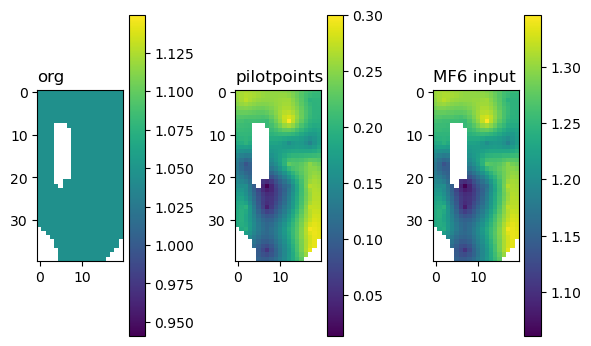

In [60]:
org_arr = np.loadtxt(os.path.join(template_ws,kh1_df.org_file.iloc[0]))
inp_arr = np.loadtxt(os.path.join(template_ws,kh1_df.model_file.iloc[0]))
mlt_arrs = [np.loadtxt(os.path.join(template_ws,afile)) for afile in kh1_df.mlt_file]
arrs = [org_arr]
arrs.extend(mlt_arrs)
arrs.append(inp_arr)
names = ["org"]
names.extend([mf.split('.')[0].split('_')[-1] for mf in kh1_df.mlt_file])
names.append("MF6 input")
fig,axes = plt.subplots(1,kh1_df.shape[0]+2,figsize=(5*kh1_df.shape[0]+1,5))
for i,ax in enumerate(axes.flatten()):
    arr = np.log10(arrs[i])
    arr[ib==0] = np.NaN
    cb = ax.imshow(arr)
    plt.colorbar(cb,ax=ax)
    ax.set_title(names[i],loc="left")
plt.tight_layout()        

# END